In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets

import numpy as np
import matplotlib.pyplot as plt


In [3]:
BATCH_SIZE = 32
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [4]:
class MNIST_CNN_V0(nn.Module):
    def __init__(self, input_size, output_size, hidden_units, image_size = 28):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(1, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units*2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units*2, hidden_units*2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units*2*(image_size//4)*(image_size//4), output_size),
        )
    
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x


In [5]:
#instatiate the model

model_v0 = MNIST_CNN_V0(28*28, 10, 32)
print(model_v0)

#loss function and optimizer
LOSS_FN = nn.CrossEntropyLoss()
OPTIMIZER = torch.optim.Adam(model_v0.parameters(), lr=0.001)

def accuracy(y_pred, y_true):
    return (torch.argmax(y_pred, dim=1) == y_true).float().mean()



MNIST_CNN_V0(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=10, bias=True)
  )
)


In [6]:
print(len(trainloader))

1875


In [7]:
from tqdm.auto import tqdm


def train_model(model, train_loader, loss_fn, optimizer, epochs=5):
  for epoch in tqdm(range(epochs)):
    model.train()
    for batch, (x, y) in enumerate(train_loader):
      y_pred = model(x)
      loss = loss_fn(y_pred, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # test the model
      model.eval()
      with torch.inference_mode():
        y_test = model(x)
        test_loss = loss_fn(y_test, y)
        test_acc = accuracy(y_test, y)

      if batch % (1875 / 5) == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}, Test Loss: {test_loss.item()}, Test Accuracy: {test_acc.item()}')
    print(f'Epoch: {epoch}, Loss: {loss.item()}')
      


c:\Users\Karolina\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
train_model(model_v0, trainloader, LOSS_FN, OPTIMIZER, epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0, Loss: 2.3062779903411865, Test Loss: 2.279794454574585, Test Accuracy: 0.125
Epoch: 0, Loss: 0.31130069494247437, Test Loss: 0.2601770758628845, Test Accuracy: 0.96875
Epoch: 0, Loss: 0.11441364884376526, Test Loss: 0.08402761816978455, Test Accuracy: 0.96875
Epoch: 0, Loss: 0.06287261843681335, Test Loss: 0.03964340686798096, Test Accuracy: 0.96875
Epoch: 0, Loss: 0.11821494996547699, Test Loss: 0.09673548489809036, Test Accuracy: 0.96875


 20%|██        | 1/5 [00:57<03:48, 57.22s/it]

Epoch: 0, Loss: 0.11158943176269531
Epoch: 1, Loss: 0.005497533828020096, Test Loss: 0.005622705444693565, Test Accuracy: 1.0
Epoch: 1, Loss: 0.024011988192796707, Test Loss: 0.018987534567713737, Test Accuracy: 1.0
Epoch: 1, Loss: 0.003804934909567237, Test Loss: 0.003506314940750599, Test Accuracy: 1.0
Epoch: 1, Loss: 0.031598515808582306, Test Loss: 0.02632829360663891, Test Accuracy: 0.96875
Epoch: 1, Loss: 0.06510888040065765, Test Loss: 0.04403158649802208, Test Accuracy: 0.96875


 40%|████      | 2/5 [01:48<02:41, 53.84s/it]

Epoch: 1, Loss: 0.0036208205856382847
Epoch: 2, Loss: 0.0003626556717790663, Test Loss: 0.00031608674908056855, Test Accuracy: 1.0
Epoch: 2, Loss: 0.03519095480442047, Test Loss: 0.009027013555169106, Test Accuracy: 1.0
Epoch: 2, Loss: 0.008945522829890251, Test Loss: 0.006010815501213074, Test Accuracy: 1.0
Epoch: 2, Loss: 0.07767304033041, Test Loss: 0.026429951190948486, Test Accuracy: 0.96875
Epoch: 2, Loss: 0.0037580791395157576, Test Loss: 0.004070347640663385, Test Accuracy: 1.0


 60%|██████    | 3/5 [02:39<01:45, 52.65s/it]

Epoch: 2, Loss: 0.016805076971650124
Epoch: 3, Loss: 0.01935577020049095, Test Loss: 0.014940221793949604, Test Accuracy: 1.0
Epoch: 3, Loss: 0.0008498536772094667, Test Loss: 0.0008669345988892019, Test Accuracy: 1.0
Epoch: 3, Loss: 0.016151852905750275, Test Loss: 0.012976763769984245, Test Accuracy: 1.0
Epoch: 3, Loss: 0.0004429526743479073, Test Loss: 0.0004180269024800509, Test Accuracy: 1.0
Epoch: 3, Loss: 0.00629925774410367, Test Loss: 0.006014701910316944, Test Accuracy: 1.0


 80%|████████  | 4/5 [03:30<00:51, 51.84s/it]

Epoch: 3, Loss: 0.0006566729280166328
Epoch: 4, Loss: 0.04470120742917061, Test Loss: 0.013085778802633286, Test Accuracy: 1.0
Epoch: 4, Loss: 0.14469587802886963, Test Loss: 0.09703300893306732, Test Accuracy: 0.96875
Epoch: 4, Loss: 0.015959646552801132, Test Loss: 0.01074950397014618, Test Accuracy: 1.0
Epoch: 4, Loss: 0.00043720848043449223, Test Loss: 0.0004862152854911983, Test Accuracy: 1.0
Epoch: 4, Loss: 0.019085850566625595, Test Loss: 0.013270440511405468, Test Accuracy: 1.0


100%|██████████| 5/5 [04:24<00:00, 52.96s/it]

Epoch: 4, Loss: 0.019478319212794304


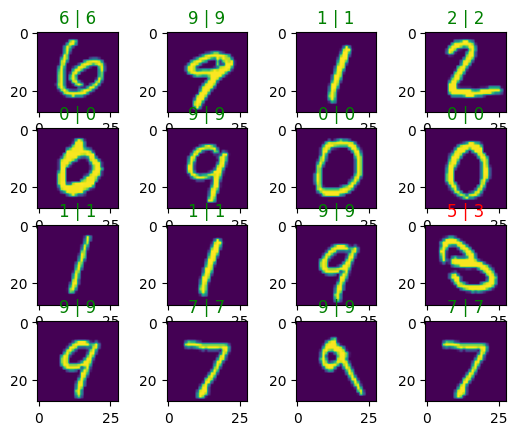

In [19]:
# the model is trained, let's test it with random 4x4 image array, where each image has title in format {pred_label | true_label} that is green if the prediction is correct, and red if it's not
import random

def test_model(model, test_loader):
  model.eval()
  with torch.inference_mode():
    for batch, (x, y) in enumerate(test_loader):
      y_pred = model(x)
      for i in range(16):
        plt.subplot(4, 4, i+1)
        idx = random.randint(0, 31)
        pred_label = torch.argmax(y_pred[idx])
        true_label = y[idx]
        plt.imshow(x[idx].squeeze().detach().numpy())
        plt.title(f'{pred_label} | {true_label}', color='green' if pred_label == true_label else 'red')

      plt.show()
      break

test_model(model_v0, testloader)

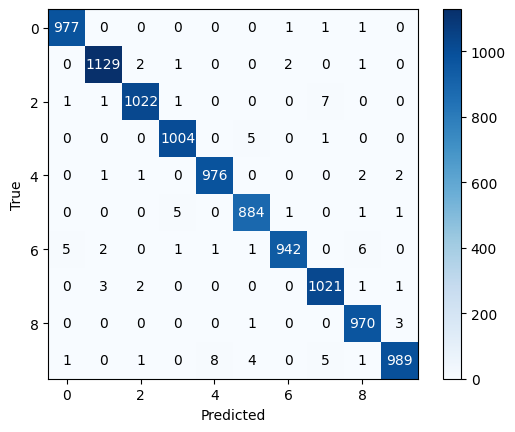

In [31]:
# let's plot the confusion matrix, that will display the numbers of correct and incorrect predictions for each class

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, test_loader):
  model.eval()
  with torch.inference_mode():
    y_true = []
    y_pred = []
    for batch, (x, y) in enumerate(test_loader):
      y_true.extend(y.numpy())
      y_pred.extend(torch.argmax(model(x), dim=1).numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, cmap='Blues')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='white' if i == j else 'black')
    plt.show()

plot_confusion_matrix(model_v0, testloader)

In [32]:
# save and load the model

from pathlib import Path

DIR_PATH = Path('models')
DIR_PATH.mkdir(exist_ok=True)

MODEL_PATH = DIR_PATH / 'mnist_cnn_v0.pth'

torch.save(model_v0.state_dict(), MODEL_PATH)


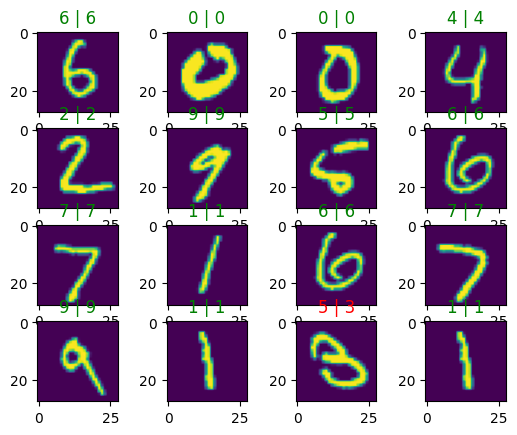

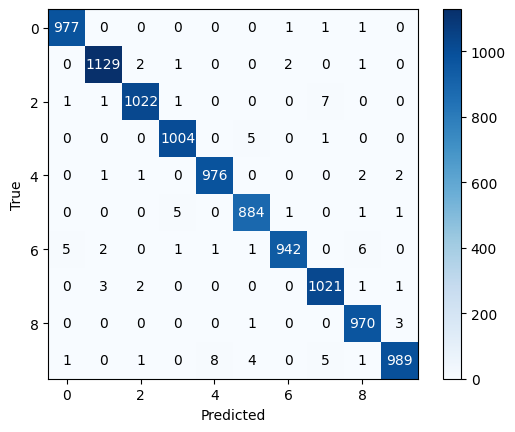

In [33]:
model_loaded = MNIST_CNN_V0(28*28, 10, 32)
model_loaded.load_state_dict(torch.load(MODEL_PATH))

test_model(model_loaded, testloader)
plot_confusion_matrix(model_loaded, testloader)